# Breast Histopathology Images

# Data Setup

In [1]:
import os
import zipfile
from shutil import copyfile

In [2]:
Datapath = '/BreastHistopathologyImages/Data/'
if not os.path.exists(Datapath):
  os.makedirs(Datapath)
os.chdir(Datapath)

In [3]:
!wget http://andrewjanowczyk.com/wp-static/IDC_regular_ps50_idx5.zip

In [4]:
Imagespath = os.path.join(Datapath,'Images')
if not os.path.exists(Imagespath):
  os.makedirs(Imagespath)

  ZipPath = os.path.join(Datapath,'IDC_regular_ps50_idx5.zip')
  DataImages_folder = Imagespath

  with zipfile.ZipFile(ZipPath, 'r') as zip_ref:
      zip_ref.extractall(DataImages_folder)

# Classifier training setup

In [5]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import cv2

In [1]:
# defining the dictionary labels for future results display:
dict_characters = {0: 'IDC:Benign(-)', 1: 'IDC:Malignant(+)'}
print(dict_characters)

{0: 'IDC:Benign(-)', 1: 'IDC:Malignant(+)'}


In [ ]:
# reading the images paths and extracting the respective class based on the 
# convention that each image is located in a folder named either 0 (Benign) or 
# 1 (Malignant)

imagePatches = glob(os.path.join(Imagespath, '**/*.png'), recursive=True)
GT_list = [int(os.path.basename(os.path.dirname(x))) for x in imagePatches]

# sanity check:
print(imagePatches[:5])
print(GT_list[:5])

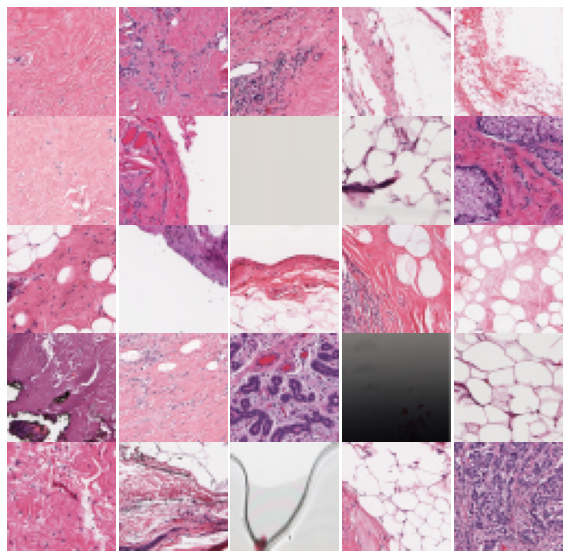

In [8]:
# Sanity check - making sure the images were downloaded and accessed properly
def display_random_patches(imagePatches):
    random_samples = random.sample(imagePatches, 25)

    i_ = 0
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i_, l in enumerate(random_samples):
        im = cv2.imread(l)
        im = cv2.resize(im, (50, 50))
        plt.subplot(5, 5, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.show()

display_random_patches(imagePatches)

# Training the Classifier

In this section I implemented a CNN based classifier of your choosing.
The data splited into training, test and validation according to a ratio of 60:20:20 (%).
I incorporated augmentations to the images.
The main metric used for performance evaluation was accuracy and precision.

In [12]:
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Total number of images: 277524
Number of IDC:Benign(-) Images: 198738
Percentage of IDC:Benign(-) Images: 71.61%
Number of IDC:Malignant(+) Images: 78786
Percentage of IDC:Malignant(+) Images: 28.39%


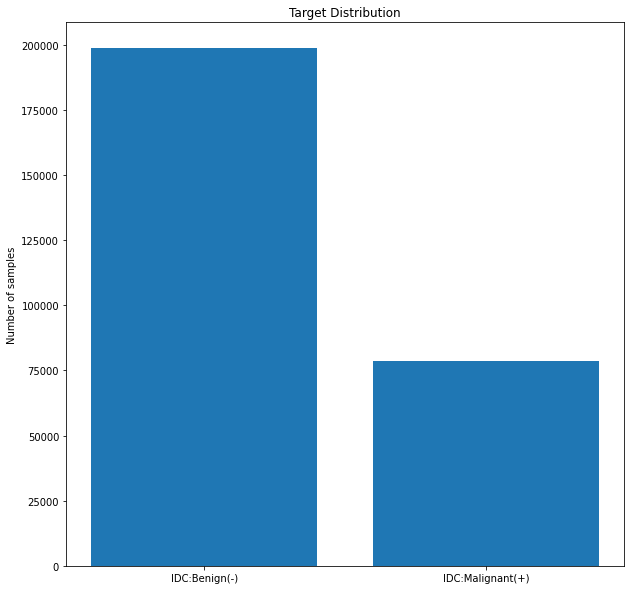

In [15]:
def describeData(target, dict_characters):
    total = target.shape[0]
    print('Total number of images: {}'.format(total))
    for cls, indx in dict_characters.items():
       images = data_output[data_output["target"]==cls].shape[0]
       print('Number of', indx, 'Images: {}'.format(images))
       print('Percentage of', indx, 'Images: {:.2f}%'.format(100*images/total))
describeData(data_output, dict_characters)

class0 = data[data["target"]==0]
class1 = data[data["target"]==1]
y_pos = np.arange(len(dict_characters.values()))
plt.bar(y_pos, [class0.shape[0],class1.shape[0]])
plt.xticks(y_pos, dict_characters.values())
plt.ylabel('Number of samples')
plt.title('Target Distribution')
plt.show()

In [16]:
#Down-sample Majority Class
data_samples = data[:153000]
train_val, test = train_test_split(data_samples, test_size=0.2)

class0 = train_val[train_val["target"]==0]
class1 = train_val[train_val["target"]==1]
df_majority_upsampled = resample(class1, replace=False, n_samples=class1.shape[0],random_state=123)
df_minority_upsampled = resample(class0, replace=False, n_samples=class1.shape[0],random_state=123)

df_downsampled  = pd.concat([df_minority_upsampled, df_majority_upsampled])
test = test[:int(df_downsampled.shape[0]/4)]

In [17]:
Data,data_output= shuffle(df_downsampled["path"],df_downsampled["target"])
images=list()
for img in Data:
    images.append(cv2.resize(cv2.imread(img),(50,50),interpolation=cv2.INTER_CUBIC))
data_output_encoded =to_categorical(data_output, num_classes=2)

Data_test,data_output_test= shuffle(test["path"],test["target"])
images_test=list()
for img in Data_test:
    images_test.append(cv2.resize(cv2.imread(img),(50,50),interpolation=cv2.INTER_CUBIC))
data_output_encoded_test =to_categorical(data_output_test, num_classes=2)

X_train, X_test, Y_train, Y_test = np.array(images), np.array(images_test), data_output_encoded, data_output_encoded_test
print("Size of train",X_train.shape[0])
print("Size of test",X_test.shape[0])
print("Size of train target",len(Y_train))
print("Size of test target",len(Y_test))

Size of train 70010
Size of test 17502
Size of train target 70010
Size of test target 17502


In [18]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25)
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_valid.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Label Data Shape:", Y_train.shape)
print("Validation Label Data Shape:", Y_valid.shape)
print("Testing Label Data Shape:", Y_test.shape)

Training Data Shape: (52507, 50, 50, 3)
Validation Data Shape: (17503, 50, 50, 3)
Testing Data Shape: (17502, 50, 50, 3)
Training Label Data Shape: (52507, 2)
Validation Label Data Shape: (17503, 2)
Testing Label Data Shape: (17502, 2)


I incorporate the following augmentations to ignore the distances, the position and the angles of the objects in the images:
rotation range, width and height shift range, zoom range, rescale.

In [19]:
data_generator = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,
                             height_shift_range=0.2, zoom_range=0.2,
                             rescale=1/255.0)
X_valid_e=X_valid/255.0
X_test_e=X_test/255.0
X_train_e=X_train/255.0

In [20]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=X_train.shape[1:]))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=2,strides=2))
model.add(Conv2D(filters=64,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(filters=512,kernel_size=(3,3),strides=2,padding='same',activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 128)        

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='AdaDelta', metrics=['accuracy'])
model_info = model.fit_generator(data_generator.flow(X_train, Y_train, 64), 
          validation_data=(X_valid_e, Y_valid), steps_per_epoch=500,
          epochs=30, verbose=1)

Epoch 1/30
500/500 [==============================] - 32s 64ms/step - loss: 0.6115 - accuracy: 0.6686 - val_loss: 0.5968 - val_accuracy: 0.6635
Epoch 2/30
500/500 [==============================] - 24s 49ms/step - loss: 0.4820 - accuracy: 0.7805 - val_loss: 0.4370 - val_accuracy: 0.8101
Epoch 3/30
500/500 [==============================] - 25s 49ms/step - loss: 0.4563 - accuracy: 0.7943 - val_loss: 0.4249 - val_accuracy: 0.8113
Epoch 4/30
500/500 [==============================] - 25s 49ms/step - loss: 0.4516 - accuracy: 0.7968 - val_loss: 0.4166 - val_accuracy: 0.8160
Epoch 5/30
500/500 [==============================] - 25s 49ms/step - loss: 0.4330 - accuracy: 0.8069 - val_loss: 0.4206 - val_accuracy: 0.8074
Epoch 6/30
500/500 [==============================] - 24s 49ms/step - loss: 0.4320 - accuracy: 0.8077 - val_loss: 0.4285 - val_accuracy: 0.8075
Epoch 7/30
500/500 [==============================] - 25s 50ms/step - loss: 0.4284 - accuracy: 0.8106 - val_loss: 0.3972 - val_accuracy:

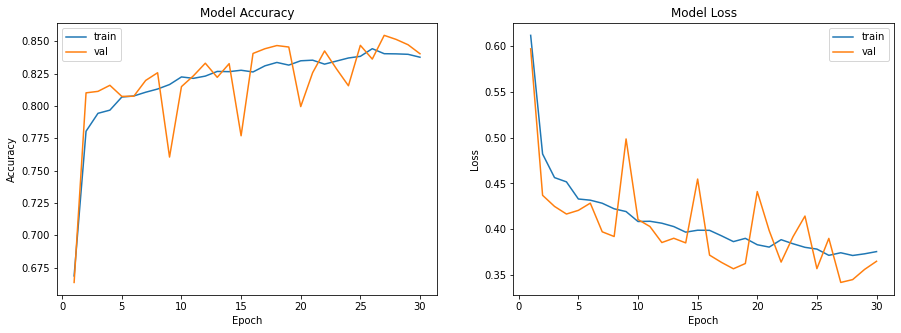

In [23]:
plot_model_history(model_info)

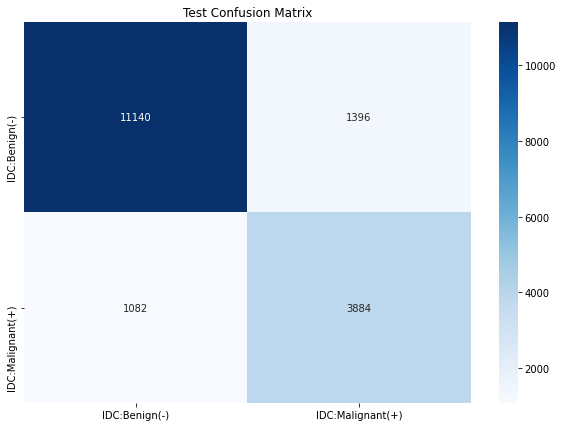

,Set,Accuracy
0,Train,0.842459
1,Validation,0.840370
2,Test,0.858416


In [24]:
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in X_test_e]
test_acc = accuracy_score(np.argmax(Y_test, axis=1),np.array(predictions))
predictions_train = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in X_train_e]
train_acc = accuracy_score(np.argmax(Y_train, axis=1),np.array(predictions_train))
predictions_val = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in X_valid_e]
val_acc = accuracy_score(np.argmax(Y_valid, axis=1),np.array(predictions_val))

cnf_matrix=confusion_matrix(np.argmax(Y_test, axis=1), np.array(predictions))
df_cm = pd.DataFrame(cnf_matrix, index = dict_characters.values(), columns = dict_characters.values())
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title("Test Confusion Matrix")
plt.show()

results=pd.DataFrame(columns=['Set', 'Accuracy'])
results.loc[0]=['Train',train_acc]
results.loc[1]=['Validation',val_acc]
results.loc[2]=['Test',test_acc]
display(results)

I use Conv2D layers with relu activation and growing filters, growing Dropout layers to avoid oferfiting, and Dense layer with softmax activation and 2 units.

I use categorical crossentropy loss with 2 categories, AdaDelta optimizer and accuracy metrics.

There are 687,682 total params in the network, all of them are trainable params.

The model isn't underfitting or overfitting because it isn't better on the training set than on the test set. In addition the train and the validation set achhived very similar accuracy and loss during the learning.

The network can be improved by using better computing resources, more data and callbacks functions to perform actions at various stages of training.

# Training using pre-trained network - **bonus**

This time I use a pre-trained network. I examined the following graph, and wanted to pick a pre-trained network. I decided to use VGG16 because its architecture is simpler and has been successful results in my previous assignments.

![alt text](https://cdn-images-1.medium.com/max/1000/1*7UXzOt97gQAmCCOL58hgAw.png)

In [26]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [27]:
vgg_model = VGG16(include_top=False,weights='imagenet', input_tensor=None, input_shape=None, pooling=None,)
vgg_train=vgg_model.predict(preprocess_input(X_train),batch_size=50,verbose=1)
vgg_valid=vgg_model.predict(preprocess_input(X_valid),batch_size=50,verbose=1)
vgg_test=vgg_model.predict(preprocess_input(X_test),batch_size=50,verbose=1)

17502/17502 [==============================] - 7s 420us/step


In [28]:
model_transfer = Sequential()
model_transfer.add(GlobalAveragePooling2D(input_shape=vgg_train.shape[1:]))
model_transfer.add(Dense(32,activation='relu'))
model_transfer.add(Dropout(0.25))
model_transfer.add(Dense(64,activation='relu'))
model_transfer.add(Dropout(0.3))
model_transfer.add(Dense(128,activation='relu'))
model_transfer.add(Dropout(0.35))
model_transfer.add(Dense(256,activation='relu'))
model_transfer.add(Dropout(0.45))
model_transfer.add(Dense(512,activation='relu'))
model_transfer.add(Dropout(0.55))
model_transfer.add(Dense(2, activation='softmax'))
model_transfer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [29]:
model_transfer.compile(loss='categorical_crossentropy', optimizer='AdaDelta', metrics=['accuracy'])
model_info = model_transfer.fit(vgg_train, Y_train, 64, validation_data=(vgg_valid, Y_valid), epochs=30, verbose=1)

Train on 52507 samples, validate on 17503 samples
Epoch 1/30
52507/52507 [==============================] - 5s 97us/step - loss: 0.5987 - accuracy: 0.7196 - val_loss: 0.4938 - val_accuracy: 0.7863
Epoch 2/30
52507/52507 [==============================] - 4s 80us/step - loss: 0.4879 - accuracy: 0.7804 - val_loss: 0.4768 - val_accuracy: 0.7929
Epoch 3/30
52507/52507 [==============================] - 4s 78us/step - loss: 0.4708 - accuracy: 0.7887 - val_loss: 0.4671 - val_accuracy: 0.7981
Epoch 4/30
52507/52507 [==============================] - 4s 79us/step - loss: 0.4633 - accuracy: 0.7944 - val_loss: 0.4634 - val_accuracy: 0.7978
Epoch 5/30
52507/52507 [==============================] - 5s 86us/step - loss: 0.4564 - accuracy: 0.7986 - val_loss: 0.4611 - val_accuracy: 0.8009
Epoch 6/30
52507/52507 [==============================] - 4s 81us/step - loss: 0.4536 - accuracy: 0.7998 - val_loss: 0.4671 - val_accuracy: 0.8007
Epoch 7/30
52507/52507 [==============================] - 4s 82us/st

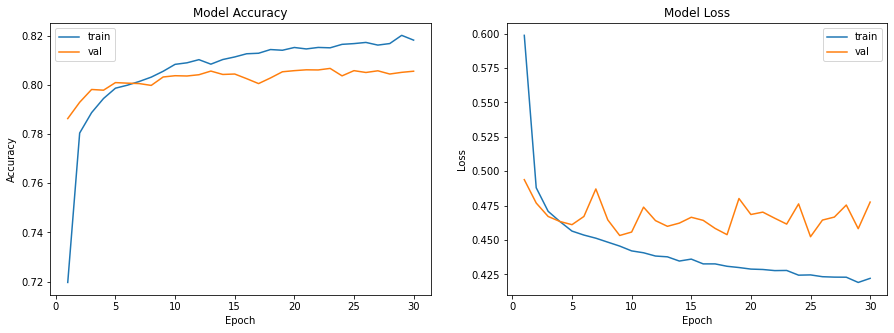

In [31]:
plot_model_history(model_info)

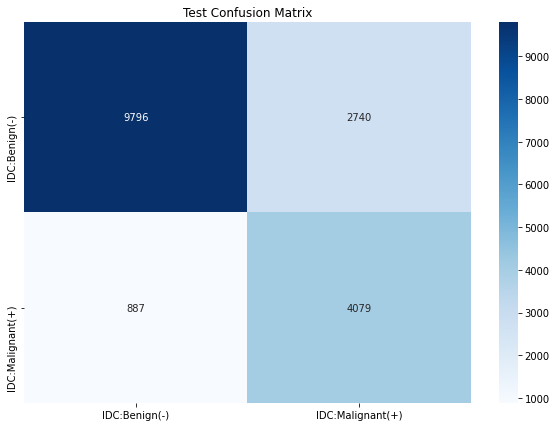

,Set,Accuracy
0,Train,0.831375
1,Validation,0.805519
2,Test,0.792767


In [32]:
predictions_transfer = [np.argmax(model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in vgg_test]
transfer_test_acc = accuracy_score(np.argmax(Y_test, axis=1),np.array(predictions_transfer))
predictions_transfer_train = [np.argmax(model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in vgg_train]
transfer_train_acc = accuracy_score(np.argmax(Y_train, axis=1),np.array(predictions_transfer_train))
predictions_transfer_val = [np.argmax(model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in vgg_valid]
transfer_val_acc = accuracy_score(np.argmax(Y_valid, axis=1),np.array(predictions_transfer_val))

cnf_matrix_transfer=confusion_matrix(np.argmax(Y_test, axis=1), np.array(predictions_transfer))
df_cm = pd.DataFrame(cnf_matrix_transfer, index = dict_characters.values(), columns = dict_characters.values())
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title("Test Confusion Matrix")
plt.show()

results=pd.DataFrame(columns=['Set', 'Accuracy'])
results.loc[0]=['Train',transfer_train_acc]
results.loc[1]=['Validation',transfer_val_acc]
results.loc[2]=['Test',transfer_test_acc]
display(results)

I import VGG16 from Keras and processed the train,validation and test set by the pre-trained network.

I use the Imagenet weights for the pre-trained network.

There are 192,482 total params, all of them are trainable params.

The model isn't underfitting or overfitting. The model doesn't much better on the training set than on the test set.

The network can be improved by using more data and by using callbacks to perform actions at various stages of training

In [33]:
tp, tn = 0, 0
for i in range(0,len(Y_test)):
    if(np.argmax(Y_test[i])==1):
        tp+=1
confusion_Arg_s=cnf_matrix[1][1]/tp *100
confusion_transfer_s=cnf_matrix_transfer[1][1]/tp*100
for i in range(0,len(Y_test)):
    if(np.argmax(Y_test[i])==1): 
        tp+=1
for i in range(0,len(Y_test)):
    if(np.argmax(Y_test[i])==0):
        tn+=1

results=pd.DataFrame(columns=['Models', 'Senstivity', 'Specificity', 'Accuracy'])
results.loc[0]=['model',confusion_Arg_s,cnf_matrix[0][0]/tn *100,test_acc]
results.loc[1]=['transfer model',confusion_transfer_s,cnf_matrix_transfer[0][0]/tn*100,transfer_test_acc]
display(results)

,Models,Senstivity,Specificity,Accuracy
0,model,78.211841,88.864071,0.858416
1,transfer model,82.138542,78.142948,0.792767
